In [1]:
# import libraries
import os
import cv2
import numpy as np
import keras
import tensorflow as tf
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from keras.applications import MobileNet
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, GlobalMaxPooling2D, Activation, Multiply, Conv2D, Concatenate, Flatten, ELU
from keras.models import Model
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from numpy.random import seed
import seaborn as sn
from keras import backend as K
import re
import mobilenet

tf.config.experimental.enable_op_determinism()

2023-04-16 15:23:41.837610: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 15:23:49.295059: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cserv1_a/soc_ug/fy19iars/project/lib/python3.9/site-packages/cv2/../../lib64:/uollinapps/AppsData/src/vscode/1.71.2-1663191299.el7/lib64
2023-04-16 15:23:49.295092: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-16 15:24:04.691631: W tensorflow/compiler/xla/stream_executor/platform/defa

Helper functions and variables

In [2]:
def list_labels(file):
    labels_file = open(file, "r")
    labels = []
    
    for line in labels_file:
        label = line.strip()
        labels.append(label)
    
    labels_file.close()
    
    return labels


#list of all labels
class_names = list_labels("./CamSDD/Labels.txt")
class_name_labels = {class_name:i for i, class_name in enumerate(class_names)}



def load_data(folder):
    Category = ["training", "test", "validation"]
    output = []
    
    for category in Category:
        print("Loading {}".format(category))
        path = os.path.join(folder, category)
        print(path)
        images = []
        labels = []
        
        for sub_folder in os.listdir(path):
            label = class_name_labels[sub_folder]
            
            #Iterating through all images
            for file in os.listdir(os.path.join(path, sub_folder)):
                
                #getting the image path
                img_path = os.path.join(os.path.join(path, sub_folder), file)
                
                #appending image and corresponding label
                images.append(cv2.resize(cv2.imread(img_path), (224, 224)))
                # images.append(cv2.imread(img_path))
                labels.append(label)
            
        images = (np.array(images, dtype='float32')/127.5)-1
        labels = np.array(labels, dtype='int8')
        
        output.append((images, labels))
        
    return output


#cited from https://stackoverflow.com/questions/49492255/how-to-replace-or-insert-intermediate-layer-in-keras-model
def insert_layer_nonseq(model, layer_regex, insert_layer_factory,
                        insert_layer_name=None, position='after'):

    # Auxiliary dictionary to describe the network graph
    network_dict = {'input_layers_of': {}, 'new_output_tensor_of': {}}

    # Set the input layers of each layer
    for layer in model.layers:
        for node in layer._outbound_nodes:
            layer_name = node.outbound_layer.name
            if layer_name not in network_dict['input_layers_of']:
                network_dict['input_layers_of'].update(
                        {layer_name: [layer.name]})
            else:
                network_dict['input_layers_of'][layer_name].append(layer.name)

    # Set the output tensor of the input layer
    network_dict['new_output_tensor_of'].update(
            {model.layers[0].name: model.input})

    # Iterate over all layers after the input
    model_outputs = []
    for layer in model.layers[1:]:

        # Determine input tensors
        layer_input = [network_dict['new_output_tensor_of'][layer_aux] 
                for layer_aux in network_dict['input_layers_of'][layer.name]]
        if len(layer_input) == 1:
            layer_input = layer_input[0]

        # Insert layer if name matches the regular expression
        if re.match(layer_regex, layer.name):
            if position == 'replace':
                x = layer_input
            elif position == 'after':
                x = layer(layer_input)
            elif position == 'before':
                pass
            else:
                raise ValueError('position must be: before, after or replace')

            new_layer = insert_layer_factory()
            if insert_layer_name:
                new_layer._name = insert_layer_name
            else:
                x = new_layer(x)
 
            if position == 'before':
                x = layer(x)
        else:
            x = layer(layer_input)

        # Set new output tensor (the original one, or the one of the inserted
        # layer)
        network_dict['new_output_tensor_of'].update({layer.name: x})

        # Save tensor in output list if it is output in initial model
        if layer_name in model.output_names:
            model_outputs.append(x)

    return Model(inputs=model.inputs, outputs=model_outputs)


# the three attention mechanisms cited from https://github.com/nikhilroxtomar/Attention-Mechanism-Implementation.git
# channel module
def channel_attention_module(x, ratio, bias):
    b, _, _, channel = x.shape
    # MLP shared layer
    l1 = Dense(channel//ratio, activation="relu", use_bias=bias)
    l2 = Dense(channel, use_bias=bias)
    
    # Global Average pooling
    x1 = GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)
    
    # Global Max pooling
    x2 = GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)
    
    # Adding both and applying sigmoid
    features = x1 + x2
    features = Activation("sigmoid")(features)
    features = Multiply()([x, features])
    
    return features

# spatial attention module
def spatial_attention_module(x):
    # Average pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)
    
    # Max pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)
    
    # Concatenate
    features = Concatenate()([x1, x2])
    
    # Conv layer
    features = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(features)
    features = Multiply()([x, features])
    
    return features
    
# CBAM
def CBAM(x, ratio=16, bias=True):
    x = channel_attention_module(x, ratio=ratio, bias=bias)
    x = spatial_attention_module(x)
    return x

def CBAM_factory():
    return CBAM

def inference_time(model):
    # the first time is just to warm up the hardware
    model.evaluate(test_images, test_labels)
    
    # measuring inference time 3 times then taking average
    start = datetime.now()
    model.evaluate(test_images, test_labels)
    end = datetime.now()
    time = end-start
    
    start2 = datetime.now()
    model.evaluate(test_images, test_labels)
    end2 = datetime.now()
    time2 = end2-start2

    start3 = datetime.now()
    model.evaluate(test_images, test_labels)
    end3 = datetime.now()
    time3 = end3-start3
    
    return (time + time2 + time3) / 3

    

Loading data

In [3]:
#loading and shuffling dataset
(train_images, train_labels), (test_images, test_labels), (validation_images, validation_labels)= load_data("./CamSDD")
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)
validation_images, validation_labels = shuffle(validation_images, validation_labels, random_state=25)

Loading training
./CamSDD/training
Loading test
./CamSDD/test
Loading validation
./CamSDD/validation


Creating and training model

In [59]:
#seed
seed(25)
tf.random.set_seed(25)
tf.keras.utils.set_random_seed(25)

#creating model using mobilenet function
base_model = mobilenet.MobileNet(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

'''
Uncomment the line below to insert attention modules
The line below only adds a single attention
The second parameter has to be modified to add more 
'''
# base_model = insert_layer_nonseq(base_model, '.*pw_(13)_relu.*', CBAM_factory)
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024, activation='sigmoid')(x)
x=Dropout(0.7)(x)
output = Dense(30, activation="softmax")(x)
model=Model(inputs=base_model.input,outputs=output)

'''
Comment the two line below to not freeze the model
'''
for layer in base_model.layers:
    layer.trainable = False
    
# training the model with an early stopping monitor
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, restore_best_weights=True)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=["accuracy", SparseTopKCategoricalAccuracy(k=3)])
history = model.fit(train_images, train_labels, batch_size=20, epochs=100, validation_data=(validation_images,validation_labels), callbacks=[monitor], shuffle=False)

Evaluating trained model

In [5]:
'''
Uncomment the line below to load a saved model
'''
# model = keras.models.load_model('CBAM_combined_relu')

score = model.evaluate(test_images, test_labels)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

average_inference_time = inference_time(model)
print('Inference time:', average_inference_time)

2023-04-16 06:09:53.800738: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cserv1_a/soc_ug/fy19iars/project/lib/python3.9/site-packages/cv2/../../lib64:/uollinapps/AppsData/src/vscode/1.71.2-1663191299.el7/lib64
2023-04-16 06:09:53.814127: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-16 06:09:53.814191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (feng-linux-04.leeds.ac.uk): /proc/driver/nvidia/version does not exist
2023-04-16 06:09:53.816847: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:

19/19 [==============================] - 10s 317ms/step - loss: 0.1801 - accuracy: 0.9583 - sparse_top_k_categorical_accuracy: 0.9917
Test loss: 0.1801312416791916
Test accuracy: 0.9583333134651184


In [6]:
# confusion matrix
test_pred = model.predict(test_images)
test_pred = np.argmax (test_pred, axis = 1)
result = confusion_matrix(test_labels, test_pred)
print(result)

19/19 [==============================] - 7s 310ms/step
[[17  0  2  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0 17  2  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0

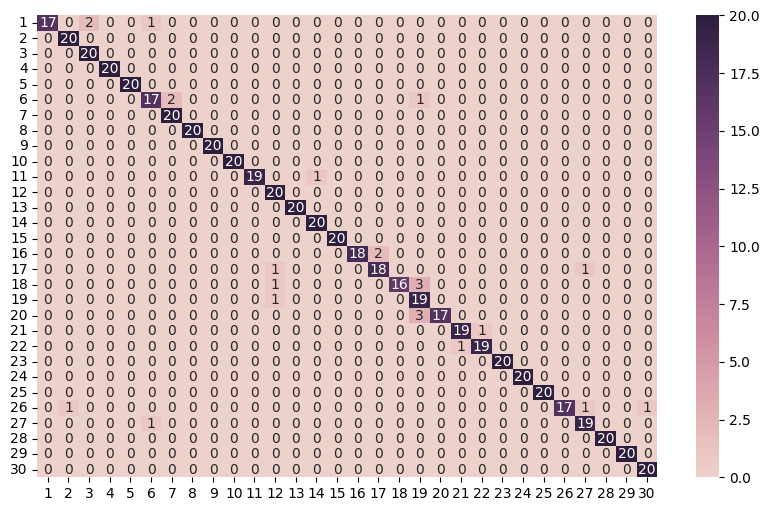

In [42]:
# using seaborn to visualise confusion matrix
plt.figure(figsize = (10,6))
ids = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
results = pd.DataFrame(result, index = [i for i in ids],
                  columns = [i for i in ids])
ax = sn.heatmap(results, annot=True, cmap=sn.cubehelix_palette(as_cmap=True))